# Load packages

In [4]:
#you might have to install those packages
#!pip install gensim
#!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 29.1 MB/s eta 0:00:0000:0100:01


In [5]:
import numpy as np
import pandas as pd
from ast import literal_eval
import re
import string
from nltk.corpus import stopwords
import nltk
from nltk.tokenize.treebank import TreebankWordDetokenizer
#from collections import Counter
from nltk.corpus import stopwords
import nltk
from gensim.utils import simple_preprocess
import gensim
from sklearn.model_selection import train_test_split
import spacy
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt 
import tensorflow as tf
import keras
import json
from sklearn.metrics import balanced_accuracy_score, f1_score, confusion_matrix

# Load datasets

In [14]:
# I uploaded the dataset on github so it's easier to upload in the notebook
data_1 = pd.read_csv('https://raw.githubusercontent.com/omerromdhani/deep_learning_project/main/SEntFiN-v1.1.csv') #FinBert has never seen this data
data_2 = pd.read_csv('https://raw.githubusercontent.com/omerromdhani/deep_learning_project/main/FinancialPhraseBank_FIQA.csv')

In [15]:
# remove multi label observation from dataset 1
pd.options.mode.chained_assignment = None 
data_1['Decisions'] = data_1['Decisions'].apply(literal_eval) #convert decisions columns to dict

for i in range(len(data_1)):
    data_1['Decisions'][i] = list(data_1['Decisions'][i].values())

data_1 = data_1[data_1['Decisions'].map(len) < 2].reset_index()

for i in range(len(data_1)):
    data_1['Decisions'][i] = data_1['Decisions'][i][0]

In [16]:
data_1 = data_1.rename(columns={'Title':'Sentence','Decisions':'Sentiment'}).sample(frac=1,random_state = 22)
#the dataset is somewhat ordered by neutral at the beginning and postivie at the end
#later we take the first 1000 obs to test, so we want a good representaion of different class

#merge the 2 datasets
df = pd.concat([data_1[['Sentence','Sentiment']], data_2[['Sentence','Sentiment']]]).reset_index(drop=True)
#df = df.sample(frac=1,random_state = 22).reset_index(drop=True) # so we dont keep the first dataset at the beggining and only test on the second

In [9]:
df['Sentiment'].value_counts()
#df['Sentiment'].isnull().sum()

neutral     5819
positive    4690
negative    3236
Name: Sentiment, dtype: int64

# Pre Process text data

In [10]:
#initialize lemmatizer
nlp = spacy.load("en_core_web_sm")

#initialize detokenizer
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)
def preprocess_data(phrase):

    # Remove new line characters
    phrase = re.sub('\s+', ' ', phrase) 

    # Remove distracting single quotes
    phrase = re.sub("\'", "", phrase) 

    # tranforms sentence into words, all lowercase, no accents, removing short and very long words
    phrase = gensim.utils.simple_preprocess(str(phrase), deacc=True) #this functions is not flexible, perhaps explore custom way to preprocess 
    
    #remove stopwords, not recommended for sentiment analysis
    #phrase = [word for word in phrase if not word in stopwords.words()]

    #group together 
    phrase = detokenize(phrase)

    #lemmatize sentence
    phrase = " ".join([token.lemma_ for token in nlp(phrase)])
         
    return phrase

In [52]:
#Splitting pd.Series to list
data_to_list = df['Sentence'].values.tolist()

# apply preprocessing
data = [preprocess_data(sentence) for sentence in data_to_list]

#save to file, so we don't have to rerun each time
with open('data_raw.json','w') as f:
    json.dump(data, f, indent=4)

In [11]:
#open raw data file
with open("data_raw.json", "r") as fp:
    data_json = json.load(fp)

#change sentiment to categories
data = np.array(data_json)

labels = np.array(df['Sentiment'])
y = []
for i in range(len(labels)):
    if labels[i] == 'neutral':
        y.append(0)
    if labels[i] == 'negative':
        y.append(1)
    if labels[i] == 'positive':
        y.append(2)
labels = tf.keras.utils.to_categorical(np.array(y), 3)
del y

In [ ]:
### NOT USED ###
#code to use word2vec pretrained from google news
import gensim.downloader as api
path = api.load("word2vec-google-news-300", return_path=True)

model = gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)

data_w2v = [model[data[phrase][word]].mean() for phrase in range(len(data)) for word in range(len(data[phrase]))]
#the model does not include stop words

#pip install tensorflow_hub
import tensorflow as tf
import tensorflow_hub as hub
elmo = hub.load("https://tfhub.dev/google/elmo/2") #pretrained elmo model

#embeddings = [elmo.signatures["default"](tf.constant(phrase))["elmo"] for phrase in data]
embedding_elmo = elmo.signatures["default"](tf.constant(data[:150]))["elmo"]

# Tokenize data

In [12]:
#We keep a sample of sentences from the SEntFiN data set to make a final performance comparaison between our model and FinBERT 
#(FinBERT has already been trained on the financial phrase bank)
sample_size = 1000
data_train = data[sample_size:]
data_test = data[0:sample_size]

labels_train = labels[sample_size:]
labels_test = labels[0:sample_size]

In [13]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

### No pretrained word embedding ###
max_words = 5000
max_len = 300

tokenizer = Tokenizer(num_words=max_words, oov_token = True)
tokenizer.fit_on_texts(data_train) #assign a intger value to each word, low integer = frequent word
sequences = tokenizer.texts_to_sequences(data_train) #apply the list of integers to the phrases
phrases = pad_sequences(sequences, maxlen=max_len)

vocab_size = len(tokenizer.word_index) + 1

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(phrases,labels_train, random_state=0, train_size= 0.75) #75% split
print (len(X_train),len(X_valid),len(y_train),len(y_valid))

9558 3187 9558 3187


## glove word embedding

In [16]:
#word embedding using Elmo pretrained model
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

# https://www.kaggle.com/datasets/danielwillgeorge/glove6b100dtxt
# the file needs to be downloaded locally to use pretrained word embedding

glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# Create and train model

In [19]:
#Parameters
batch_size = 128
epochs = 50
earlystop = EarlyStopping(monitor = 'val_accuracy',min_delta = 0,patience = 6, verbose = 1,restore_best_weights = True)

def model_fit(checkpoint):
    return model.fit(X_train, y_train, batch_size = batch_size, epochs=epochs,
                     validation_data=(X_valid, y_valid),
                     callbacks=[checkpoint,earlystop])

## Regular LSTM

In [20]:
model = Sequential()
model.add(layers.Embedding(max_words, 40, input_length=max_len)) # without pr trained word embedding
model.add(layers.LSTM(20,dropout=0.6))
model.add(layers.Dense(3,activation='softmax'))
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint = ModelCheckpoint("LSTM.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto',save_weights_only=False)

#model.fit(X_train, y_train, batch_size = 128, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint,earlystop])
model_fit(checkpoint)

Epoch 1/50
74/75 [============================>.] - ETA: 0s - loss: 1.0189 - accuracy: 0.4843
Epoch 1: val_accuracy improved from -inf to 0.52275, saving model to LSTM.hdf5
75/75 [==============================] - 6s 38ms/step - loss: 1.0172 - accuracy: 0.4854 - val_loss: 0.9522 - val_accuracy: 0.5227
Epoch 2/50
74/75 [============================>.] - ETA: 0s - loss: 0.8819 - accuracy: 0.5854
Epoch 2: val_accuracy improved from 0.52275 to 0.62818, saving model to LSTM.hdf5
75/75 [==============================] - 2s 28ms/step - loss: 0.8824 - accuracy: 0.5846 - val_loss: 0.8427 - val_accuracy: 0.6282
Epoch 3/50
74/75 [============================>.] - ETA: 0s - loss: 0.8028 - accuracy: 0.6326
Epoch 3: val_accuracy improved from 0.62818 to 0.66144, saving model to LSTM.hdf5
75/75 [==============================] - 2s 29ms/step - loss: 0.8029 - accuracy: 0.6323 - val_loss: 0.8112 - val_accuracy: 0.6614
Epoch 4/50
73/75 [============================>.] - ETA: 0s - loss: 0.7483 - accuracy

## BiRNN

In [21]:
# without pr trained word embedding
model = Sequential()
model.add(layers.Embedding(max_words, 40, input_length=max_len)) 
model.add(layers.Bidirectional(layers.LSTM(40,dropout=0.6)))
model.add(layers.Dense(3,activation='softmax'))
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint = ModelCheckpoint("BiRNN.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto',save_weights_only=False)
earlystop = EarlyStopping(monitor = 'val_accuracy',min_delta = 0,patience = 6, verbose = 1,restore_best_weights = True)

model_fit(checkpoint)

#with glove word embedding
model = Sequential()
model.add(layers.Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False, input_length=max_len))
model.add(layers.Bidirectional(layers.LSTM(40,dropout=0.6)))
model.add(layers.Dense(3,activation='softmax'))
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint = ModelCheckpoint("BiRNN_glove.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto',save_weights_only=False)
model_fit(checkpoint)

Epoch 1/50
75/75 [==============================] - ETA: 0s - loss: 1.0367 - accuracy: 0.4899
Epoch 1: val_accuracy improved from -inf to 0.54879, saving model to BiRNN.hdf5
75/75 [==============================] - 8s 63ms/step - loss: 1.0367 - accuracy: 0.4899 - val_loss: 0.9629 - val_accuracy: 0.5488
Epoch 2/50
75/75 [==============================] - ETA: 0s - loss: 0.9089 - accuracy: 0.5880
Epoch 2: val_accuracy improved from 0.54879 to 0.63508, saving model to BiRNN.hdf5
75/75 [==============================] - 4s 47ms/step - loss: 0.9089 - accuracy: 0.5880 - val_loss: 0.8289 - val_accuracy: 0.6351
Epoch 3/50
74/75 [============================>.] - ETA: 0s - loss: 0.7867 - accuracy: 0.6738
Epoch 3: val_accuracy improved from 0.63508 to 0.69846, saving model to BiRNN.hdf5
75/75 [==============================] - 4s 48ms/step - loss: 0.7862 - accuracy: 0.6743 - val_loss: 0.7193 - val_accuracy: 0.6985
Epoch 4/50
75/75 [==============================] - ETA: 0s - loss: 0.6506 - accur

## Stacked BiRNN

In [22]:
#without word embedding
model = Sequential()
model.add(layers.Embedding(max_words, 40, input_length=max_len)) # without pr trained word embedding
model.add(layers.Bidirectional(layers.LSTM(40,dropout=0.6, return_sequences = True)))
model.add(layers.Bidirectional(layers.LSTM(40,dropout=0.6)))
model.add(layers.Dense(3,activation='softmax'))
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint = ModelCheckpoint("BiRNNx2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto',save_weights_only=False)

model_fit(checkpoint)

#with glove word embedding
model = Sequential()
model.add(layers.Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False, input_length=max_len))
model.add(layers.Bidirectional(layers.LSTM(40,dropout=0.6, return_sequences = True)))
model.add(layers.Bidirectional(layers.LSTM(40,dropout=0.6)))
model.add(layers.Dense(3,activation='softmax'))
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint = ModelCheckpoint("BiRNNx2_glove.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto',save_weights_only=False)

model_fit(checkpoint)

Epoch 1/50
75/75 [==============================] - ETA: 0s - loss: 0.9988 - accuracy: 0.4967
Epoch 1: val_accuracy improved from -inf to 0.62567, saving model to BiRNNx2.hdf5
75/75 [==============================] - 16s 118ms/step - loss: 0.9988 - accuracy: 0.4967 - val_loss: 0.8792 - val_accuracy: 0.6257
Epoch 2/50
75/75 [==============================] - ETA: 0s - loss: 0.7618 - accuracy: 0.6816
Epoch 2: val_accuracy improved from 0.62567 to 0.73361, saving model to BiRNNx2.hdf5
75/75 [==============================] - 6s 84ms/step - loss: 0.7618 - accuracy: 0.6816 - val_loss: 0.6578 - val_accuracy: 0.7336
Epoch 3/50
75/75 [==============================] - ETA: 0s - loss: 0.6013 - accuracy: 0.7621
Epoch 3: val_accuracy improved from 0.73361 to 0.75400, saving model to BiRNNx2.hdf5
75/75 [==============================] - 6s 77ms/step - loss: 0.6013 - accuracy: 0.7621 - val_loss: 0.6059 - val_accuracy: 0.7540
Epoch 4/50
75/75 [==============================] - ETA: 0s - loss: 0.5227

In [45]:
from keras.utils import plot_model
plot_model(best_model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


## Conv1d

In [42]:
model = Sequential()
model.add(layers.Embedding(max_words, 40, input_length=max_len))
model.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(3,activation='softmax'))
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
metric = 'val_accuracy'
checkpoint = ModelCheckpoint("conv1d.hdf5", monitor=metric, verbose=1, save_best_only=True, mode='auto', save_weights_only=False)



model_conv = model.fit(X_train, y_train, batch_size = batch_size, epochs=epochs,
                     validation_data=(X_valid, y_valid),
                     callbacks=[checkpoint])

Epoch 1/50
70/75 [===========================>..] - ETA: 0s - loss: 1.6375 - accuracy: 0.4281
Epoch 1: val_accuracy improved from -inf to 0.42924, saving model to conv1d.hdf5
75/75 [==============================] - 2s 20ms/step - loss: 1.6156 - accuracy: 0.4277 - val_loss: 1.2613 - val_accuracy: 0.4292
Epoch 2/50
72/75 [===========================>..] - ETA: 0s - loss: 1.1401 - accuracy: 0.4311
Epoch 2: val_accuracy did not improve from 0.42924
75/75 [==============================] - 1s 10ms/step - loss: 1.1383 - accuracy: 0.4305 - val_loss: 1.0810 - val_accuracy: 0.4292
Epoch 3/50
70/75 [===========================>..] - ETA: 0s - loss: 1.0813 - accuracy: 0.4294
Epoch 3: val_accuracy did not improve from 0.42924
75/75 [==============================] - 1s 8ms/step - loss: 1.0811 - accuracy: 0.4305 - val_loss: 1.0750 - val_accuracy: 0.4292
Epoch 4/50
73/75 [============================>.] - ETA: 0s - loss: 1.0781 - accuracy: 0.4300
Epoch 4: val_accuracy did not improve from 0.42924
7

In [27]:
def eval_model(model):
    #load best model from validation acc results
    best_model = keras.models.load_model(model)
    predictions = best_model.predict(X_valid, verbose = 0)

    y_true = y_valid.argmax(axis=1)
    y_hat = np.around(predictions, decimals=0).argmax(axis=1)

    #balanced accuracy
    bal_acc = balanced_accuracy_score(y_true, y_hat)

    #macro F1
    f_score = f1_score(y_true, y_hat, average="macro")
    print(f'Validation Score for {model[:-5]}')
    print(f'balanced accurracy:{bal_acc}')
    print(f'f1 macro:{f_score}\n')

In [43]:
list_models = ["LSTM.hdf5","BiRNN.hdf5","BiRNN_glove.hdf5","BiRNNx2.hdf5","BiRNNx2_glove.hdf5","conv1d.hdf5"]

In [44]:
for model in list_models:
    eval_model(model)

Validation Score for LSTM
balanced accurracy:0.7621967114691798
f1 macro:0.7694905932529837

Validation Score for BiRNN
balanced accurracy:0.7736028226573581
f1 macro:0.7840732853713003

Validation Score for BiRNN_glove
balanced accurracy:0.7133144734477964
f1 macro:0.7288496388738778

Validation Score for BiRNNx2
balanced accurracy:0.760033988151895
f1 macro:0.7644630512211484

Validation Score for BiRNNx2_glove
balanced accurracy:0.7434819878915789
f1 macro:0.7547564628935189

Validation Score for conv1d
balanced accurracy:0.3333333333333333
f1 macro:0.20021953896816683



<AxesSubplot:>

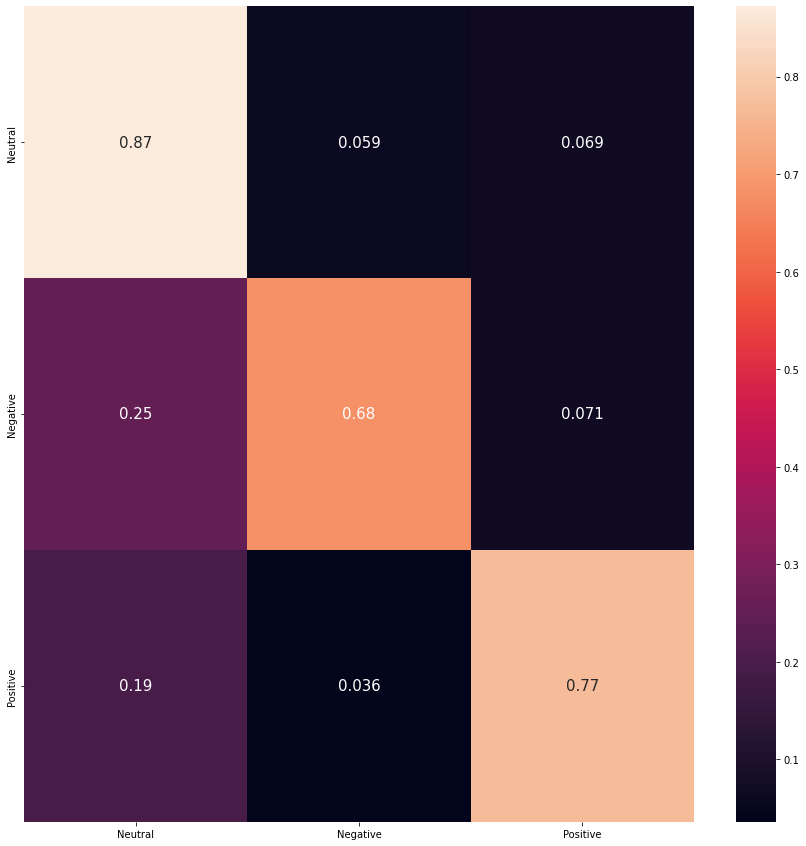

In [29]:

best_model = keras.models.load_model("BiRNN.hdf5")
predictions = best_model.predict(X_valid, verbose = 0)

y_true = y_valid.argmax(axis=1)
y_hat = np.around(predictions, decimals=0).argmax(axis=1)
matrix = confusion_matrix(y_true, y_hat)

conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

## Results on the test set with the final model

In [36]:
sequences = tokenizer.texts_to_sequences(data_test) #apply the list of integers to the phrases
test_phrases = pad_sequences(sequences, maxlen=max_len)

predictions = best_model.predict(test_phrases, verbose = 0)

y_true = labels_test.argmax(axis=1)
y_hat = np.around(predictions, decimals=0).argmax(axis=1)

#balanced accuracy
bal_acc = balanced_accuracy_score(y_true, y_hat)
#macro F1
f_score = f1_score(y_true, y_hat, average="macro")

print('Test Score')
print(f'balanced accurracy:{bal_acc}')
print(f'f1 macro:{f_score}')

Test Score
balanced accurracy:0.806968549077995
f1 macro:0.8096027261170712


# FinBERT Implementation

we use the pretrained model FinBERT to compare the performance with our model

In [1]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [9]:
#you may have to restart the kernel in order to use the pytorch framework
#if so, you have to load again the datasets into the memory
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from transformers.pipelines.base import KeyDataset
import time
from datasets import Dataset

model_finbert = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

classifier = pipeline(
    task="text-classification", 
    model=model_finbert, 
    tokenizer=tokenizer, 
    device=0
    )

In [24]:
sample_size = 1000
data_test = data_1[['Sentence','Sentiment']][0:sample_size]

#create dataset item to use pipeline in batch
dataset = Dataset.from_pandas(data_test)


fin_score= []
for out in classifier(KeyDataset(dataset, "Sentence"), batch_size=8):
    fin_score.append(out)

# Final model comparison

In [25]:
#FinBERT results
y_pred_fin = [fin_score[i]['label'] for i in range(len(data_test))]
y_true_fin = data_test['Sentiment'].values.tolist()

acc_fin = balanced_accuracy_score(y_pred_fin, y_true_fin)
f1_fin = f1_score(y_pred_fin, y_true_fin, average="macro")

print(f'balanced accurracy:{acc_fin}')
print(f'f1 macro:{f1_fin}')

balanced accurracy:0.7307552329274095
f1 macro:0.72412569239115
